In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Pytorch-Models/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/.shortcut-targets-by-id/1aJsbt04Jz9xcLP_lg7fvP4Bpdce6GQlC/Pytorch-Models


In [ ]:
# STEP 1: Install compatible PyTorch (2.0.1 + CUDA 11.7)
!pip install torch==2.0.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

# STEP 2: Install OpenMMLab tools
!pip install -U openmim
!mim install "mmengine>=0.7.4"
!mim install "mmcv==2.1.0"

# STEP 3: Clone MMDetection & install
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -e .

In [2]:
# STEP 4: Final check
!python -c "import torch; import mmcv; import mmdet; print('PyTorch:', torch.__version__); print('MMCV:', mmcv.__version__); print('MMDet:', mmdet.__version__)"

PyTorch: 2.0.1+cu117
MMCV: 2.1.0
MMDet: 3.3.0


In [ ]:
!pip install numpy==1.24.4

In [3]:
!ls mmdetection/configs/mask_rcnn/

mask-rcnn_r101-caffe_fpn_1x_coco.py
mask-rcnn_r101-caffe_fpn_ms-poly-3x_coco.py
mask-rcnn_r101_fpn_1x_coco.py
mask-rcnn_r101_fpn_2x_coco.py
mask-rcnn_r101_fpn_8xb8-amp-lsj-200e_coco.py
mask-rcnn_r101_fpn_ms-poly-3x_coco.py
mask-rcnn_r18_fpn_8xb8-amp-lsj-200e_coco.py
mask-rcnn_r50-caffe-c4_1x_coco.py
mask-rcnn_r50-caffe_fpn_1x_coco.py
mask-rcnn_r50-caffe_fpn_ms-1x_coco.py
mask-rcnn_r50-caffe_fpn_ms-poly-1x_coco.py
mask-rcnn_r50-caffe_fpn_ms-poly-2x_coco.py
mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco.py
mask-rcnn_r50-caffe_fpn_poly-1x_coco_v1.py
mask-rcnn_r50_fpn_1x_coco.py
mask-rcnn_r50_fpn_1x-wandb_coco.py
mask-rcnn_r50_fpn_2x_coco.py
mask-rcnn_r50_fpn_8xb8-amp-lsj-200e_coco.py
mask-rcnn_r50_fpn_amp-1x_coco.py
mask-rcnn_r50_fpn_markers.py
mask-rcnn_r50_fpn_ms-poly-3x_coco.py
mask-rcnn_r50_fpn_poly-1x_coco.py
mask-rcnn_x101-32x4d_fpn_1x_coco.py
mask-rcnn_x101-32x4d_fpn_2x_coco.py
mask-rcnn_x101-32x4d_fpn_ms-poly-3x_coco.py
mask-rcnn_x101-32x8d_fpn_1x_coco.py
mask-rcnn_x101-32x8d_fpn_ms-poly

In [ ]:
custom_cfg = """
_base_ = 'mask-rcnn_r50_fpn_ms-poly-3x_coco.py'

# Custom classes
dataset_type = 'CocoDataset'
metainfo = dict(classes=("CAP",))
num_classes = 1

# Paths
data_root = '/content/gdrive/MyDrive/Pytorch-Models/datasets/'
train_ann = data_root + 'markerpensseg/train/_annotations.coco.json'
val_ann = data_root + 'markerpensseg/valid/_annotations.coco.json'
train_img = data_root + 'markerpensseg/train/'
val_img = data_root + 'markerpensseg/valid/'

# Normalization
img_norm_cfg = dict(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)

# Pipelines
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize', scale=(512, 512), keep_ratio=False),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Pad', size=(512, 512), pad_val=dict(img=(114, 114, 114))),
    dict(type='PackDetInputs')
]

test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(512, 512), keep_ratio=False),
    dict(type='Pad', size=(512, 512), pad_val=dict(img=(114, 114, 114))),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='PackDetInputs', meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape', 'scale_factor'))
]

# Data loader
train_dataloader = dict(
    batch_size=8,
    num_workers=2,
    dataset=dict(
        _delete_=True,
        type=dataset_type,
        data_root=data_root,
        ann_file=train_ann,
        data_prefix=dict(img=train_img),
        filter_cfg=dict(filter_empty_gt=True, min_size=32),
        pipeline=train_pipeline,
        metainfo=dict(classes=("CAP",)),
    )
)

val_dataloader = dict(
    batch_size=8,
    num_workers=2,
    dataset=dict(
        _delete_=True,
        type=dataset_type,
        data_root=data_root,
        ann_file=val_ann,
        data_prefix=dict(img=val_img),
        pipeline=test_pipeline,
        test_mode=True,
        metainfo=dict(classes=("CAP",)),
    )
)

test_dataloader = val_dataloader

# Evaluator
val_evaluator = dict(type='CocoMetric', ann_file=val_ann, metric=['bbox', 'segm'])
# val_evaluator = dict(type='CocoMetric', ann_file=val_ann, metric=['bbox', 'segm'], classwise=True)
test_evaluator = val_evaluator

# Model
model = dict(
    type='MaskRCNN',
    data_preprocessor=dict(
        type='DetDataPreprocessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_mask=True,
        pad_size_divisor=32),
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[.0, .0, .0, .0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
    roi_head=dict(
        type='StandardRoIHead',
        bbox_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=7, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        bbox_head=dict(
            type='Shared2FCBBoxHead',
            in_channels=256,
            fc_out_channels=1024,
            roi_feat_size=7,
            num_classes=num_classes,
            bbox_coder=dict(
                type='DeltaXYWHBBoxCoder',
                target_means=[0., 0., 0., 0.],
                target_stds=[0.1, 0.1, 0.2, 0.2]),
            reg_class_agnostic=False,
            loss_cls=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
        mask_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=14, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        mask_head=dict(
            type='FCNMaskHead',
            num_convs=4,
            in_channels=256,
            conv_out_channels=256,
            num_classes=num_classes,
            loss_mask=dict(
                type='CrossEntropyLoss', use_mask=True, loss_weight=1.0))),
    # model training and testing settings
    train_cfg=dict(
        rpn=dict(
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.7,
                neg_iou_thr=0.3,
                min_pos_iou=0.3,
                match_low_quality=True,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=256,
                pos_fraction=0.5,
                neg_pos_ub=-1,
                add_gt_as_proposals=False),
            allowed_border=-1,
            pos_weight=-1,
            debug=False),
        rpn_proposal=dict(
            nms_pre=2000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0),
        rcnn=dict(
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.5,
                neg_iou_thr=0.5,
                min_pos_iou=0.5,
                match_low_quality=True,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=512,
                pos_fraction=0.25,
                neg_pos_ub=-1,
                add_gt_as_proposals=True),
            mask_size=28,
            pos_weight=-1,
            debug=False)),
    test_cfg=dict(
        rpn=dict(
            nms_pre=1000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0),
        rcnn=dict(
            score_thr=0.05,
            nms=dict(type='nms', iou_threshold=0.5),
            max_per_img=100,
            mask_thr_binary=0.5)))

# Schedule
train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=10, val_interval=1)
val_cfg = dict(type='ValLoop')
test_cfg = dict(type='TestLoop')

# Optimizer
optim_wrapper = dict(
    optimizer=dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0001),
    clip_grad=None
)

# Learning policy
param_scheduler = [
    dict(type='LinearLR', start_factor=0.1, by_epoch=False, begin=0, end=30),
    dict(
        type='MultiStepLR',
        begin=0,
        end=10,
        by_epoch=True,
        milestones=[7, 9],
        gamma=0.1
    )
]

# Logging and checkpointing
default_hooks = dict(
    logger=dict(type='LoggerHook', interval=2),
    checkpoint=dict(type='CheckpointHook', interval=2)
)

# Output path
work_dir = '/content/gdrive/MyDrive/Pytorch-Models/mmdetection/mmdet_outputs/mask-rcnn_r50_fpn_markers'

# Load pretrained COCO model
load_from = 'https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_fpn_mstrain-poly_3x_coco_20210524_201154-21b550bb.pth'
"""

with open('mmdetection/configs/mask_rcnn/mask-rcnn_r50_fpn_markers.py', 'w') as f:
    f.write(custom_cfg)

In [ ]:
!python mmdetection/tools/train.py mmdetection/configs/mask_rcnn/mask-rcnn_r50_fpn_markers.py --amp

Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.1+cu117
02/14 16:57:51 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 897271463
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.5, V12.5.82
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA R

In [ ]:
!python mmdetection/tools/test.py mmdetection/configs/mask_rcnn/mask-rcnn_r50_fpn_markers.py mmdetection/mmdet_outputs/mask-rcnn_r50_fpn_markers/epoch_10.pth

Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.1+cu117
02/14 17:04:51 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1234544697
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.5, V12.5.82
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA 

In [4]:
from mmdet.apis import init_detector, inference_detector
import mmcv

# Config and checkpoint paths
config_file = 'mmdetection/configs/mask_rcnn/mask-rcnn_r50_fpn_markers.py'
checkpoint_file = 'mmdetection/mmdet_outputs/mask-rcnn_r50_fpn_markers/epoch_10.pth'

# Initialize the model
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or 'cpu'

# Image path
img = '/content/gdrive/MyDrive/Pytorch-Models/datasets/markerpensseg/valid/1B3246F6-8785-4465-AC56-3BE7AA44003D_jpeg.rf.ddd6b9b6921d9589dfae0019661b06a1.jpg'

# Run inference
result = inference_detector(model, img)
print(result)

Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.1+cu117


Loads checkpoint by local backend from path: mmdetection/mmdet_outputs/mask-rcnn_r50_fpn_markers/epoch_10.pth
<DetDataSample(

    META INFORMATION
    pad_shape: (512, 512)
    img_path: '/content/gdrive/MyDrive/Pytorch-Models/datasets/markerpensseg/valid/1B3246F6-8785-4465-AC56-3BE7AA44003D_jpeg.rf.ddd6b9b6921d9589dfae0019661b06a1.jpg'
    ori_shape: (2048, 1536)
    img_shape: (512, 512)
    img_id: 0
    batch_input_shape: (512, 512)
    scale_factor: (0.3333333333333333, 0.25)

    DATA FIELDS
    ignored_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            bboxes: tensor([], device='cuda:0', size=(0, 4))
            masks: BitmapMasks(num_masks=0, height=2048, width=1536)
            labels: tensor([], device='cuda:0', dtype=torch.int64)
        ) at 0x7daf33d8c310>
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            bboxes: tensor([[ 831.3538, 1145.3986, 1040

Loads checkpoint by local backend from path: mmdetection/mmdet_outputs/mask-rcnn_r50_fpn_markers/epoch_10.pth


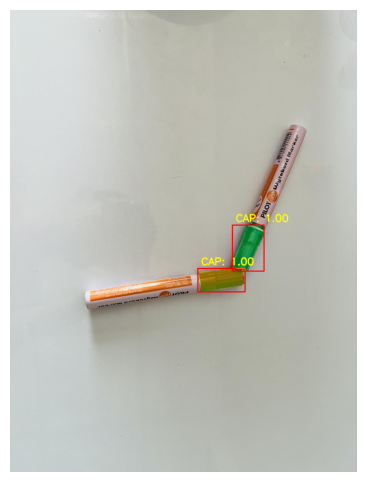

In [7]:
from mmdet.apis import init_detector, inference_detector
import mmcv
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
import random

# Class labels
CLASS_LABELS = ["CAP"]

PRED_COLORS = {0: (0, 255, 0)}

# Config and checkpoint paths
config_file = 'mmdetection/configs/mask_rcnn/mask-rcnn_r50_fpn_markers.py'
checkpoint_file = 'mmdetection/mmdet_outputs/mask-rcnn_r50_fpn_markers/epoch_10.pth'

# Initialize the model
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or 'cpu'

def draw_bbox_with_label(img, bbox, label, score, color=(0, 0, 255), thickness=3):
    xmin, ymin, xmax, ymax = map(int, bbox)
    # Draw rectangle
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, thickness)
    # Put label text
    cv2.putText(
        img, f"{label}: {score:.2f}", (xmin + 15, ymin - 15),
        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 3, cv2.LINE_AA
    )

# Image path
img_path = '/content/gdrive/MyDrive/Pytorch-Models/datasets/markerpensseg/valid/1B3246F6-8785-4465-AC56-3BE7AA44003D_jpeg.rf.ddd6b9b6921d9589dfae0019661b06a1.jpg'
img = cv2.imread(img_path)
if img is None:
    raise Exception("Image not found or unreadable")

# Run inference
results = inference_detector(model, img_path)

# Access the prediction results from the DetDataSample object
pred_instances = results.pred_instances

CONF_THRESHOLD = 0.3
img_with_masks = img.copy()

# Draw boxes and labels
# pred_instances.bboxes, pred_instances.scores, and pred_instances.labels are tensors
for i in range(len(pred_instances.bboxes)):
    score = pred_instances.scores[i]
    if score < CONF_THRESHOLD:
        continue

    # 1. Get Class and Color
    label_id = pred_instances.labels[i].item()
    class_name = CLASS_LABELS[label_id]
    color = PRED_COLORS[label_id]

    # 2. Extract and Process Mask
    # pred_instances.masks is a boolean tensor of shape (N, H, W)
    mask = pred_instances.masks[i].cpu().numpy()

    # Create a colored version of the mask
    colored_mask = np.zeros_like(img, dtype=np.uint8)
    colored_mask[mask] = color

    # 3. Overlay Mask onto Image (Alpha Blending)
    alpha = 0.4  # Transparency level
    img_with_masks = cv2.addWeighted(img_with_masks, 1.0, colored_mask, alpha, 0)

    # 4. Draw Bounding Box and Label
    bbox = pred_instances.bboxes[i].tolist()
    draw_bbox_with_label(img_with_masks, bbox, class_name, score, color=(0, 0, 255))

# Show result
img_with_bbox_rgb = cv2.cvtColor(img_with_masks, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(img_with_bbox_rgb)
plt.show()

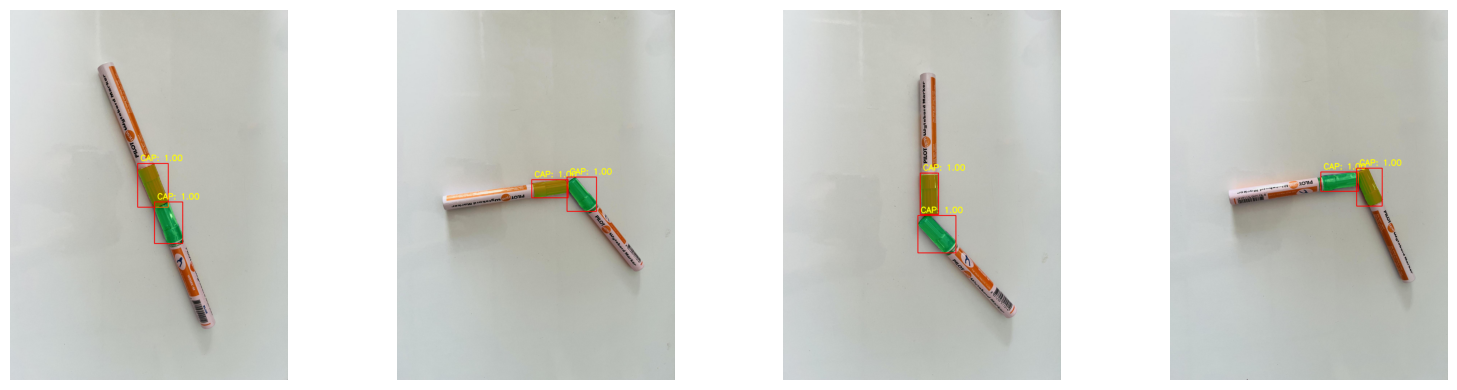

In [8]:
# ---------------- CONFIG ----------------
val_dir = "/content/gdrive/MyDrive/Pytorch-Models/datasets/markerpensseg/valid/"

# visualization layout
N = 4
cols = 4
rows = int(np.ceil(N / cols))

# random image selection
all_imgs = [os.path.join(val_dir, f)
            for f in os.listdir(val_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))]

sample_imgs = random.sample(all_imgs, N)

plt.figure(figsize=(4 * cols, 4 * rows))

for ii, image in enumerate(sample_imgs):
    plt.subplot(1, 4, ii+1)

    img = cv2.imread(image)

    results = inference_detector(model, image)

    # Access the prediction results from the DetDataSample object
    pred_instances = results.pred_instances

    CONF_THRESHOLD = 0.3
    img_with_masks = img.copy()

    # Draw boxes and labels
    # pred_instances.bboxes, pred_instances.scores, and pred_instances.labels are tensors
    for i in range(len(pred_instances.bboxes)):
        score = pred_instances.scores[i]
        if score < CONF_THRESHOLD:
            continue

        # 1. Get Class and Color
        label_id = pred_instances.labels[i].item()
        class_name = CLASS_LABELS[label_id]
        color = PRED_COLORS[label_id]

        # 2. Extract and Process Mask
        # pred_instances.masks is a boolean tensor of shape (N, H, W)
        mask = pred_instances.masks[i].cpu().numpy()

        # Create a colored version of the mask
        colored_mask = np.zeros_like(img, dtype=np.uint8)
        colored_mask[mask] = color

        # 3. Overlay Mask onto Image (Alpha Blending)
        alpha = 0.4  # Transparency level
        img_with_masks = cv2.addWeighted(img_with_masks, 1.0, colored_mask, alpha, 0)

        # 4. Draw Bounding Box and Label
        bbox = pred_instances.bboxes[i].tolist()
        draw_bbox_with_label(img_with_masks, bbox, class_name, score, color=(0, 0, 255))

    plt.subplot(rows, cols, ii + 1)
    plt.imshow(cv2.cvtColor(img_with_masks, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.tight_layout()
plt.show()